In [ ]:
!pip install transformers scipy scikit-learn

In [ ]:
import json
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from scipy.stats import spearmanr
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
with open("train.json") as f:
    train_data = json.load(f)

with open("dev.json") as f:
    dev_data = json.load(f)

In [ ]:
def story_key(sample):
    return (
        sample["precontext"].strip(),
        sample["sentence"].strip(),
        sample["ending"].strip()
    )

train_stories = defaultdict(list)
for t_s in train_data.values():
    train_stories[story_key(t_s)].append(t_s)

dev_stories = defaultdict(list)
for d_s in dev_data.values():
    dev_stories[story_key(d_s)].append(d_s)

In [ ]:
train_keys = list(train_stories.keys())
val_keys = list(dev_stories.keys())


def collect(keys, stories):
    samples = []
    for k in keys:
        samples.extend(stories[k])
    return samples


train_samples = collect(train_keys, train_stories)
val_samples = collect(val_keys, dev_stories)

print(len(train_samples), len(val_samples))


2280 588


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class AmbiStoryDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        ending = s["ending"].strip()
        if ending == "":
            ending = "[NO ENDING]"

        story = f"{s['precontext']} {s['sentence']} {ending}"
        sense = f"{s['judged_meaning']}. {s['example_sentence']}"

        enc = tokenizer(
            story,
            sense,
            truncation=True,
            padding="max_length",
            max_length=256,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "label": torch.tensor(s["average"], dtype=torch.float),
            "stdev": torch.tensor(s["stdev"], dtype=torch.float),
            "story_id": story_key(s)
        }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_ds = AmbiStoryDataset(train_samples)
val_ds = AmbiStoryDataset(val_samples)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

In [ ]:
class OrdinalBERT_STDM(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        self.stdm = nn.Sequential(
            nn.Linear(768, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.out = nn.Linear(128, 1)
        nn.init.constant_(self.out.bias, 3.0)

    def forward(self, input_ids, attention_mask):
        out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled = out.pooler_output
        h = self.stdm(pooled)
        score = self.out(h).squeeze()

        return score

In [ ]:
def ranking_loss(preds, labels, story_ids, margin=0.5):
    loss = 0.0
    count = 0

    by_story = defaultdict(list)
    for p, y, sid in zip(preds, labels, story_ids):
        by_story[sid].append((p, y))

    for pairs in by_story.values():
        if len(pairs) < 2:
            continue
        (p1, y1), (p2, y2) = pairs[:2]
        if y1 == y2:
            continue
        sign = torch.sign(y1 - y2)
        loss += torch.relu(margin - sign * (p1 - p2))
        count += 1

    return loss / max(count, 1)

In [ ]:
def evaluate(model, loader):
    model.eval()
    preds, gold = [], []

    with torch.no_grad():
        for batch in loader:
            p = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )
            preds.extend(p.cpu().numpy())
            gold.extend(batch["label"].numpy())

    return spearmanr(preds, gold).correlation, preds, gold

In [ ]:
model = OrdinalBERT_STDM().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

mse = nn.MSELoss()
lam = 1.0

train_losses, val_spearman = [], []
best_val = -1

for epoch in range(10):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        preds = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )

        labels = batch["label"].to(device)
        r_loss = ranking_loss(preds, labels,
                              batch["story_id"])
        m_loss = mse(preds, labels)

        loss = m_loss + lam * r_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    sp, _, _ = evaluate(model, val_loader)
    val_spearman.append(sp)

    if sp > best_val:
        best_val = sp
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Epoch {epoch+1} | Loss {train_losses[-1]:.4f} | Val Spearman {sp:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 | Loss 1.4565 | Val Spearman 0.0310
Epoch 2 | Loss 1.4149 | Val Spearman 0.1794
Epoch 3 | Loss 1.2419 | Val Spearman 0.1930
Epoch 4 | Loss 0.9953 | Val Spearman 0.2546
Epoch 5 | Loss 0.7501 | Val Spearman 0.2747
Epoch 6 | Loss 0.5441 | Val Spearman 0.2768
Epoch 7 | Loss 0.4038 | Val Spearman 0.2824
Epoch 8 | Loss 0.3188 | Val Spearman 0.3355
Epoch 9 | Loss 0.2158 | Val Spearman 0.2978
Epoch 10 | Loss 0.1646 | Val Spearman 0.3260


In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

final_spearman, final_preds, final_gold = evaluate(model, val_loader)
print("FINAL Spearman:", final_spearman)

correct = 0
for p, g, s in zip(final_preds, final_gold, val_ds.samples):
    if abs(p - g) <= max(1.0, s["stdev"]):
        correct += 1

print("Accuracy within STD:", correct / len(final_gold))


FINAL Spearman: 0.3354568169498607
Accuracy within STD: 0.6496598639455783


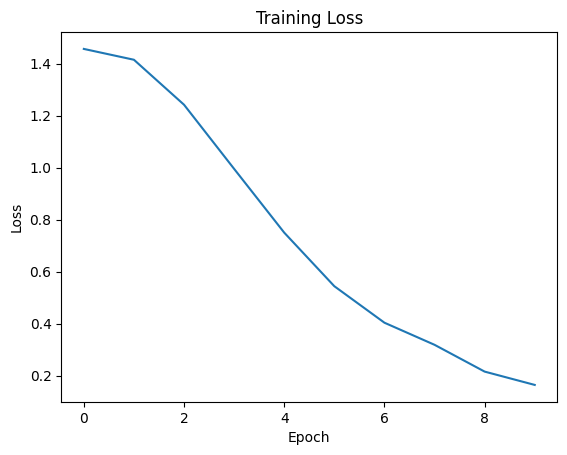

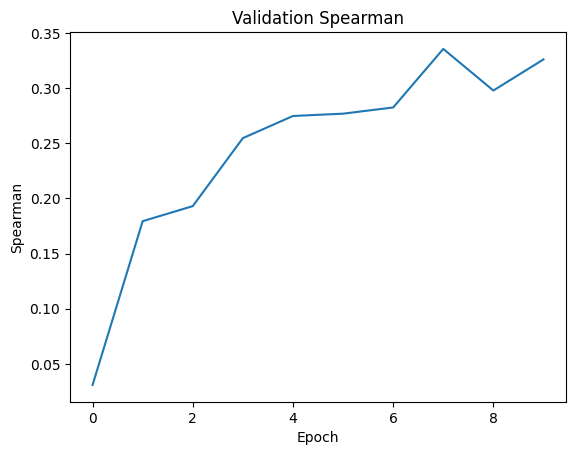

In [ ]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(val_spearman)
plt.title("Validation Spearman")
plt.xlabel("Epoch")
plt.ylabel("Spearman")
plt.show()

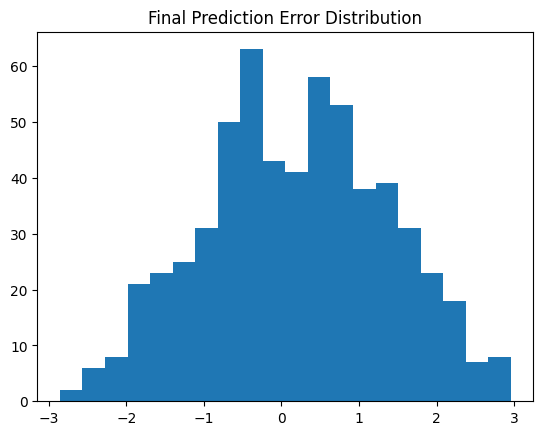

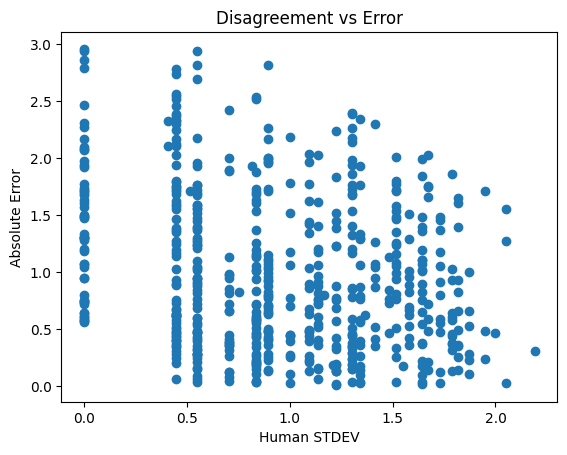

In [ ]:
errors = np.array(final_preds) - np.array(final_gold)

plt.figure()
plt.hist(errors, bins=20)
plt.title("Final Prediction Error Distribution")
plt.show()

plt.figure()
plt.scatter(
    [s["stdev"] for s in val_ds.samples],
    np.abs(errors)
)
plt.xlabel("Human STDEV")
plt.ylabel("Absolute Error")
plt.title("Disagreement vs Error")
plt.show()